In [122]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from skimage.feature import hog
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [146]:
root = '.'
os.listdir(root)

['.DS_Store',
 'test',
 'Project2.pdf',
 'model.joblib',
 'train',
 'evaluation',
 'README.txt']

# Task 1

In [135]:
def print_image(img):
    plt.imshow(img)
    plt.show()

In [136]:
parking_lots = [
    [(1597, 872), (1566, 1031), (1754, 1042), (1759, 943)],
    [(1456, 783), (1407, 909), (1557, 944), (1578, 833)],
    [(1346, 703), (1288, 803), (1416, 840), (1449, 740)],
    [(1239, 643), (1180, 737), (1293, 762), (1335, 688)],
    [(1159, 591), (1089, 675), (1187, 708), (1240, 634)],
    [(1094, 559), (1009, 630), (1087, 654), (1147, 583)],
    [(1025, 506), (952, 571), (1024, 593), (1089, 532)],
    [(975, 474), (896, 532), (953, 550), (1012, 491)],
    [(914, 439), (844, 497), (893, 519), (961, 453)],
    [(876, 414), (792, 466), (834, 486), (909, 430)]
]

### Prepare data

In [137]:
def extract_and_warp_roi(image, coords):
    # define the destination points for perspective transformation
    width, height = 200, 200 
    dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')
    src_points = np.array(coords, dtype='float32')

    # warp the ROI to a top-down view
    M = cv.getPerspectiveTransform(src_points, dst_points)
    warped_roi = cv.warpPerspective(image, M, (width, height))

    return warped_roi

In [138]:
def extract_hog_features(roi):
    gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    hog_features = hog(
        gray, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        transform_sqrt=True
    )

    return hog_features

def prepare_data(images, gts=None):
    warped_rois = []

    for image in images:
        warped_rois.extend([extract_and_warp_roi(image, coords) for coords in parking_lots])

    hog_features = [extract_hog_features(roi) for roi in warped_rois]
    
    if gts is None:
        return np.array(hog_features)

    labels = []
    for gt in gts:
        labels.extend(gt)

    return np.array(hog_features), np.array(labels)

### [Can be skipped] Load training data

In [139]:
def load_train_data(path):
    img = cv.imread(f'{root}/train/Task1/{path}.jpg')
    with open(f'{root}/train/Task1/ground-truth-complete/{path}_gt.txt', 'r') as f:
        gt = [int(x.split()[1]) for x in f.readlines()[1:]]
        
    return img, gt

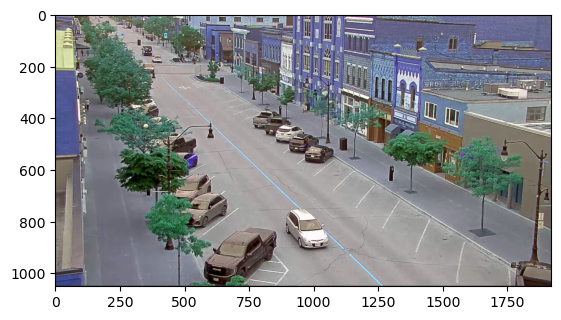

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [140]:
images = []
gts = []

for i in range(1, 16):
    if i <= 10:
        img_count = 3
    else:
        img_count = 4

    for j in range(1, img_count + 1):
        if i < 10:
            path = f'0{i}_{j}'
        else:
            path = f'{i}_{j}'
        
        img, gt = load_train_data(path)
        images.append(img)
        gts.append(gt)

images = np.array(images)
gts = np.array(gts)

print_image(images[0])
gts[0]

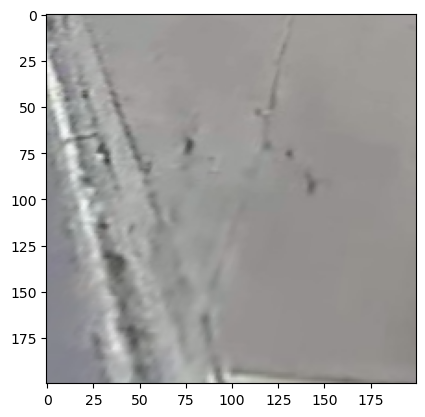

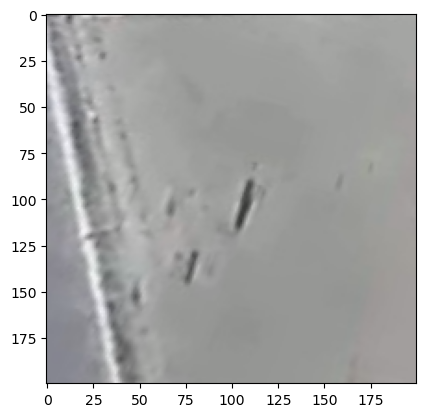

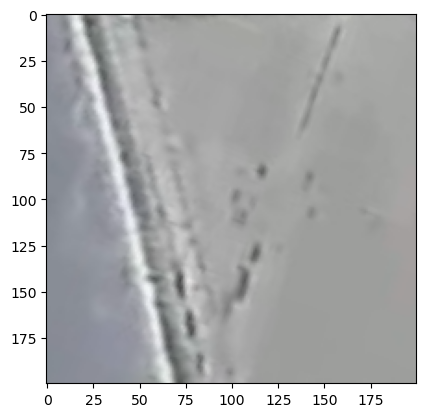

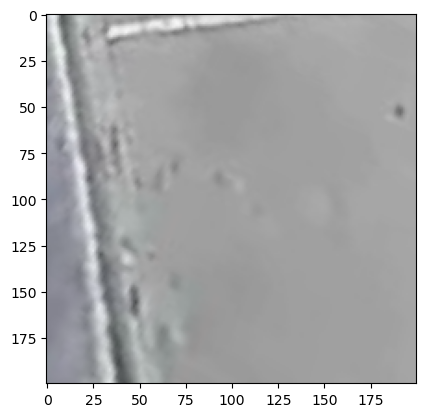

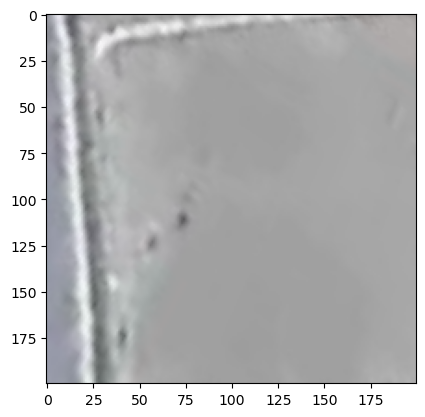

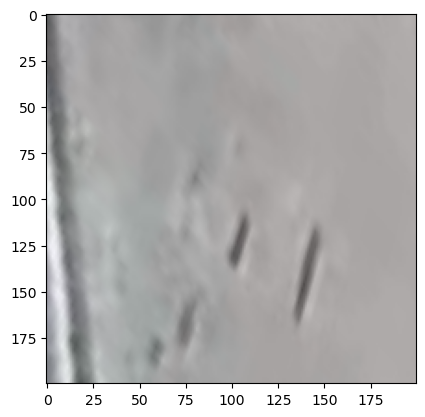

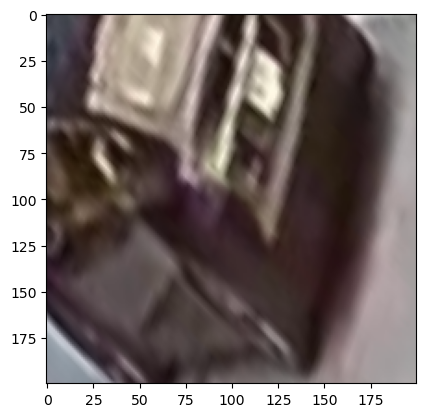

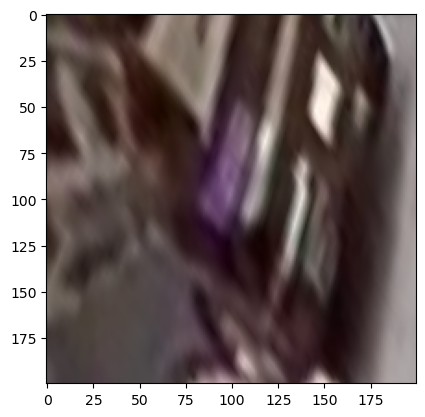

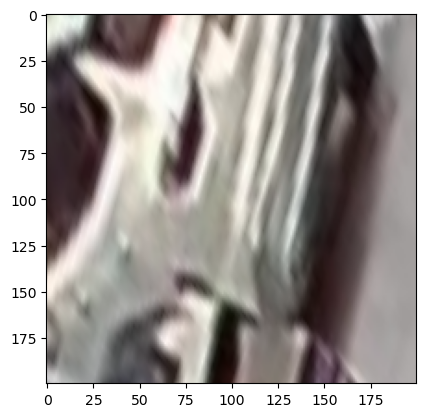

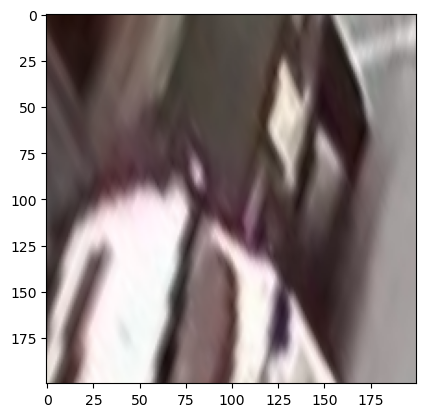

In [141]:
warped_rois = [extract_and_warp_roi(images[0], coords) for coords in parking_lots]

for i, roi in enumerate(warped_rois):
    print_image(roi)

### [Can be skipped] Train and save the model

In [142]:
X_train, y_train = prepare_data(images, gts)
print(X_train.shape)
print(y_train.shape)

(500, 20736)
(500,)


In [143]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [149]:
dump(model, f'{root}/model.joblib')

['./model.joblib']

### Test

In [150]:
model = load(f'{root}/model.joblib')

In [151]:
def load_test_data(path):
    img = cv.imread(f'{root}/test/Task1/{path}.jpg')
    with open(f'{root}/test/Task1/{path}_query.txt', 'r') as f:
        query = [int(x.split()[0]) for x in f.readlines()[1:]]
        
    return img, query

In [152]:
results_path = f'{root}/submission_files/407_Bejenariu_David_Cosmin/Task1'
if not os.path.exists(results_path):
    os.makedirs(results_path)

for i in range(1, 16):
    if i <= 10:
        img_count = 3
    else:
        img_count = 4

    for j in range(1, img_count + 1):
        if i < 10:
            path = f'0{i}_{j}'
        else:
            path = f'{i}_{j}'

        img, query = load_test_data(path)
        lots = prepare_data([img])

        X_test = []
        for q in query:
            X_test.append(lots[q - 1])
        X_test = np.array(X_test)

        print(X_test.shape, query)
        y_test = model.predict(X_test)

        with open(f'{results_path}/{path}_predicted.txt', 'w') as f:
            f.write(f'{y_test.shape[0]}\n')
            
            for k, label in enumerate(y_test):
                f.write(f'{query[k]} {label}')

                if k < len(y_test) - 1:
                    f.write('\n')

(3, 20736) [1, 3, 7]
(2, 20736) [4, 6]
(3, 20736) [2, 4, 5]
(2, 20736) [1, 7]
(1, 20736) [10]
(3, 20736) [3, 6, 7]
(2, 20736) [1, 2]
(3, 20736) [5, 7, 9]
(2, 20736) [4, 6]
(3, 20736) [8, 9, 10]
(2, 20736) [4, 9]
(2, 20736) [8, 10]
(3, 20736) [1, 3, 7]
(2, 20736) [2, 5]
(1, 20736) [6]
(2, 20736) [5, 7]
(3, 20736) [1, 3, 9]
(2, 20736) [8, 9]
(3, 20736) [2, 3, 10]
(3, 20736) [1, 8, 9]
(2, 20736) [3, 8]
(2, 20736) [1, 5]
(2, 20736) [5, 9]
(3, 20736) [6, 7, 8]
(3, 20736) [1, 5, 6]
(2, 20736) [8, 9]
(1, 20736) [3]
(3, 20736) [1, 2, 5]
(2, 20736) [3, 7]
(3, 20736) [5, 7, 8]
(3, 20736) [1, 4, 5]
(2, 20736) [6, 7]
(2, 20736) [3, 6]
(1, 20736) [7]
(4, 20736) [2, 3, 5, 6]
(2, 20736) [1, 3]
(3, 20736) [7, 8, 10]
(3, 20736) [2, 3, 8]
(2, 20736) [4, 5]
(3, 20736) [2, 6, 9]
(1, 20736) [10]
(2, 20736) [3, 4]
(2, 20736) [1, 6]
(3, 20736) [1, 2, 5]
(2, 20736) [2, 7]
(3, 20736) [4, 5, 6]
(3, 20736) [2, 3, 9]
(2, 20736) [4, 6]
(3, 20736) [1, 2, 9]
(3, 20736) [1, 3, 9]


# Task 2

In [153]:
def get_final_frame(video_path):
    cap = cv.VideoCapture(video_path)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    cap.set(cv.CAP_PROP_POS_FRAMES, total_frames - 1)
    _, frame = cap.read()
    cap.release()
    
    return frame

In [154]:
model = load(f'{root}/model.joblib')

In [155]:
results_path2 = f'{root}/submission_files/407_Bejenariu_David_Cosmin/Task2'
if not os.path.exists(results_path2):
    os.makedirs(results_path2)

for i in range(1, 16):
    if i < 10:
        path = f'0{i}'
    else:
        path = str(i)
    
    img = get_final_frame(f'{root}/train/Task2/{path}.mp4')
    X_test = np.array(prepare_data([img]))

    print(X_test.shape)

    y_test = model.predict(X_test)
    with open(f'{results_path2}/{path}_predicted.txt', 'w') as f:
        for i, label in enumerate(y_test):
            f.write(str(label))

            if i < len(y_test) - 1:
                f.write('\n')

(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)
(10, 20736)


### [Don't run these cells] Code for parking lots selection and model evaluation

In [ ]:
image_path = f'{root}/train/Task1/14_1.jpg'
image = cv.imread(image_path)
image_copy = image.copy()

points = []

def mouse_callback(event, x, y, flags, param):
    global points, image_copy

    if event == cv.EVENT_LBUTTONDOWN:
        points.append((x, y))
        # draw a circle on the selected point
        cv.circle(image_copy, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image", image_copy)
        
        # if 4 points are selected, store and reset
        if len(points) == 4:
            print(f"Parking space corners: {points}")
            with open('parking_space_corners.txt', 'a') as file:
                file.write(f"{points}\n")
            points = []
            image_copy = image.copy()

cv.imshow("Image", image_copy)
cv.setMouseCallback("Image", mouse_callback)

# keep the window open until 'q' is pressed
while True:
    cv.imshow("Image", image_copy)
    key = cv.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv.destroyAllWindows()

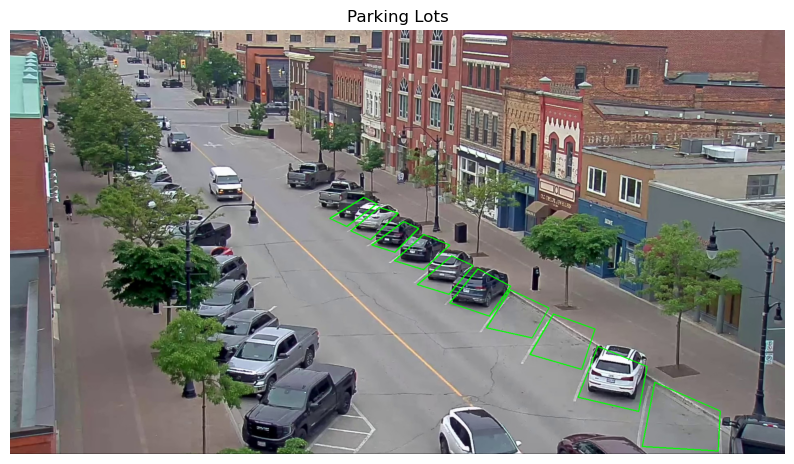

In [99]:
image_path = f'{root}/train/Task1/01_3.jpg'
image = cv.imread(image_path)

# draw lines for each parking lot
for lot in parking_lots:
    for i in range(len(lot)):
        start_point = lot[i]
        end_point = lot[(i + 1) % len(lot)]
        cv.line(image, start_point, end_point, (0, 255, 0), 2)

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title("Parking Lots")
plt.axis('off')
plt.show()

In [ ]:
accuracy = model.score(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

y_pred = model.predict(X_test)
print("Predicted labels:", y_pred)
print("True labels:", y_test)